# Imports

In [1]:
# Base imports
import os

# Mathematical imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Environment
import gym
import gym_env

# Algorithms
from stable_baselines3 import TD3, A2C, DDPG, SAC, PPO, DQN, HerReplayBuffer

# Machine learning imports
from sklearn.metrics import confusion_matrix, accuracy_score

# Nbimporter allows to import from other files in jupyter notebook
import nbimporter
from lib import *

# Matplotlib settings
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)

# Setting const variables

In [2]:
# Algorithms
algorithms = {
    "td3" : TD3,
    "a2c" : A2C,
    "ddpg" : DDPG,
    "sac" : SAC,
    "ppo" : PPO,
}

# Directory for training logs
log_dir = "tmp/"

# Reading data from csv

In [4]:
# Thermal data
df = pd.read_csv('../data/thm/processed_thermal_data.csv')

# EPS data
#df = pd.read_csv('../../data/eps/processed_test_power_measurements_2.csv')

# User settings
- episode_length is the max number of steps that the agent can correlate
- obs_size is the number of time steps that the agent observes
- train_timesteps is the number of time steps that training is going for
- predict_iter is the number of time steps that have to be predicted

In [5]:
# Choosing the parameter or multiple parameters (not yet implemented)
columns = ["B1_temp"]

# Choosing the model number from models that have been trained
model_num = 1

# Choosing appropriate algorithm
algorithm_name = "ddpg"
algorithm = algorithms[algorithm_name]

# Training parameters
predict_iter = 10000
episode_length = 100 # needed for environment setup and to find the correct model
obs_size = 1 # needed for environment setup and to find the correct model

# Data pre-processing

In [1]:
# Extracting the latest number of data points
# Total number of data points = 110000
# Data points are used for training = 100000
# Preferably to use predict_iter <= 10000 = (110000 - 100000)
df = df.iloc[-predict_iter:]

# Finds anomalies by setting a threshold to use as a reference for accuracy calculation
df = find_anomalies(df, columns)

#data reshaping
data_pre = df[columns].values
data = data_pre.reshape((data_pre.shape[0],))

# Data is normalized within the environment again. !!!!!
# However, the normalizer is set in order to denormalized data after prediction !!!!!!
normalizer = Normalizer(data)

NameError: name 'df' is not defined

# Environment setup

In [7]:
env = gym.make("Anomaly-v4", data=data, episode_length=episode_length, obs_size=obs_size)
obs = env.reset(force=True)

# Model loading

In [10]:
model = algorithm.load(f"tmp/best_models/{algorithm_name}_models/{'-'.join(columns)}/OBS_{obs_size}/EL_{episode_length}/model_{model_num}", env=env)
obs = env.reset(force=True) # just in case

# Setting numpy arrays for data collection for analysis

In [11]:
actions = np.zeros(predict_iter)
observations = np.zeros(predict_iter)
rewards = np.zeros(predict_iter)

# Prediction

In [12]:
for i in range(predict_iter):
    action, _states = model.predict(obs)
    actions[i] = action
    obs, reward, done, info = env.step(action)
    observations[i] = obs[-1]
    rewards[i] = reward
    if done:
        obs = env.reset()
env.close() 

# Post-processing

In [13]:
# Denormalizing
predictions = normalizer.denormalize(actions)
values = normalizer.denormalize(observations) 

# Getting anomalies indexes
anomalies_predicted_pos = np.where(rewards<0)[0]

# Creating anomalies array
anomalies_predicted = np.zeros(len(values))
anomalies_predicted[anomalies_predicted_pos] = 1

# Getting a numpy array of anomalies for reference
anomalies_ref = df["Anomaly_ref"].values

# Plotting

In [14]:
# Choose plotting range
start = 0
end = 10000 # max = predict_iter

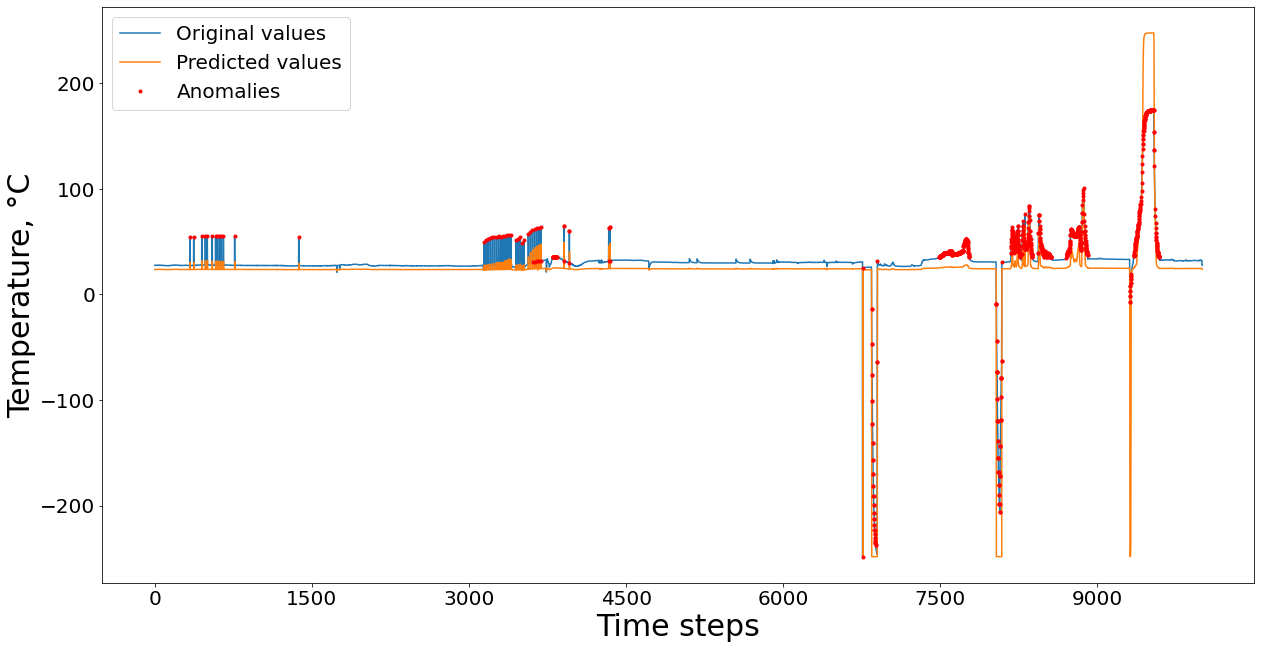

In [15]:
# X-axis
index = np.arange(len(values))

# Setting figure up
fig = plt.figure(figsize =(20, 10))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
max_xticks = 10
xloc = plt.MaxNLocator(max_xticks)
ax.xaxis.set_major_locator(xloc)

ax.plot(index[start:end], values[start:end], label="Original values")
ax.plot(index[start:end], predictions[start:end], label="Predicted values")
ax.plot(anomalies_predicted_pos[start:end], values[anomalies_predicted_pos][start:end], marker = 'o', ms = 3, mec = 'r', mfc = 'r', linestyle = "None", label="Anomalies")
ax.set_xlabel('Time steps', fontsize=30)
ax.set_ylabel('Temperature, °C', fontsize=30)
ax.legend(fontsize=20)
plt.show()
plt.close(fig)


# Metrics

In [16]:
cm = confusion_matrix(anomalies_ref,anomalies_predicted)
print("true_negative", cm[0][0])
print("false_negative", cm[1][0])
print("true_positive", cm[1][1])
print("false_positive",  cm[0][1])

accuracy = accuracy_score(anomalies_ref, anomalies_predicted)
print(accuracy)

true_negative 8706
false_negative 101
true_positive 722
false_positive 471
0.9428
